##Exercise Session 5: Regularized least-squares and gradient descent methods

In this fifth notebook, you will have your first hands-on application on parametric methods in machine learning. We shall see how to use python to solve least-squared problems, and how to implement gradient descent for optimizing different functions. You will also gain intuition about various gradient descent methods by visualizing and applying these methods to some simple two-dimensional surfaces. Methods studied include ordinary gradient descent, gradient descent with momentum and NAG.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams["figure.figsize"] = (9, 9)
plt.rcParams["font.size"] = 16
np.random.seed(40)

## Ridge Regression

First, we need to discuss the many ways to solve the minimization problem. We are going to assume that we are interested in the Ridge problem:

$$
\hat{\mathbf{w}} = \arg \min_{\mathbf{w}} \left( \frac{1}{n} \| \mathbf{y} - X \mathbf{w} \|_2^2 + \lambda \| \mathbf{w} \|_2^2 \right)
$$

with $\mathbf{y} \in \mathbb{R}^n$, $\mathbf{w} \in \mathbb{R}^p$, and $X$ a $n \times p$ matrix. We have shown in the lecture that the solution should satisfy the normal equations:

$$
(X^T X + \lambda \mathbf{I}_p) \hat{\mathbf{w}} = X^T \mathbf{y}
$$

For any positive $\lambda$, the solution is unique (question: why?) and can be written either as (question: why are these matrices invertible?)
$$
\hat{\mathbf{w}} = (X^T X + n \lambda \mathbf{I}_p)^{-1} X^T \mathbf{y} = X^T (X X^T + n \lambda \mathbf{I}_n)^{-1} \mathbf{y}
$$

We shall see how to use these formulae. First we import the function \texttt{inv}, that allows us to invert matrices (indeed, if they are invertible).


In [2]:
from scipy.linalg import inv   #This function allows us to invert matrices
import timeit

#Then we generate an artificial set of data for the problem, using randn to create an n x p matrix "X" and a n-dimensional vector "y", in both of which every element is generated randomly according to a Normal distribution of unitary variance.

p = 50 #number of features
n = 250 #number of data points

X = np.random.randn(n,p)
y = np.random.randn(n,1)
lamb = 0.01

Nrep = 100

w1 = inv(X.T@X+n*lamb*np.eye(p,p))@X.T@y   #Formula 1 for w vector
t1 = timeit.timeit('inv(X.T@X+n*lamb*np.eye(p,p))@X.T@y',"from __main__ import n,p,X,y,lamb,inv,np", number=Nrep)/Nrep  #The timeit.timeit function measures the time taken to execute each formula Nrep times.
print("formula 1 took :",t1,"ms \n and the result is w1=",w1[:3],"...")

w2 = X.T@inv(X@X.T+n*lamb*np.eye(n,n))@y   #Formula 2 for w vector
t2 = timeit.timeit('X.T@inv(X@X.T+n*lamb*np.eye(n,n))@y',"from __main__ import n,p,X,y,lamb,inv,np", number=Nrep)/Nrep
print("formula 2 took :",t2,"ms \n and the result is w2=",w2[:3],"...")

formula 1 took : 0.003302615919999994 ms 
 and the result is w1= [[ 0.0680873]
 [ 0.0020364]
 [-0.1135461]] ...
formula 2 took : 0.06596421992999993 ms 
 and the result is w2= [[ 0.0680873]
 [ 0.0020364]
 [-0.1135461]] ...


As excpected the results are the same as the formulas are equivalent, yet the time changes.

We repeat your experiment for different values of
 and
 to understand when it is better to use one or the other.

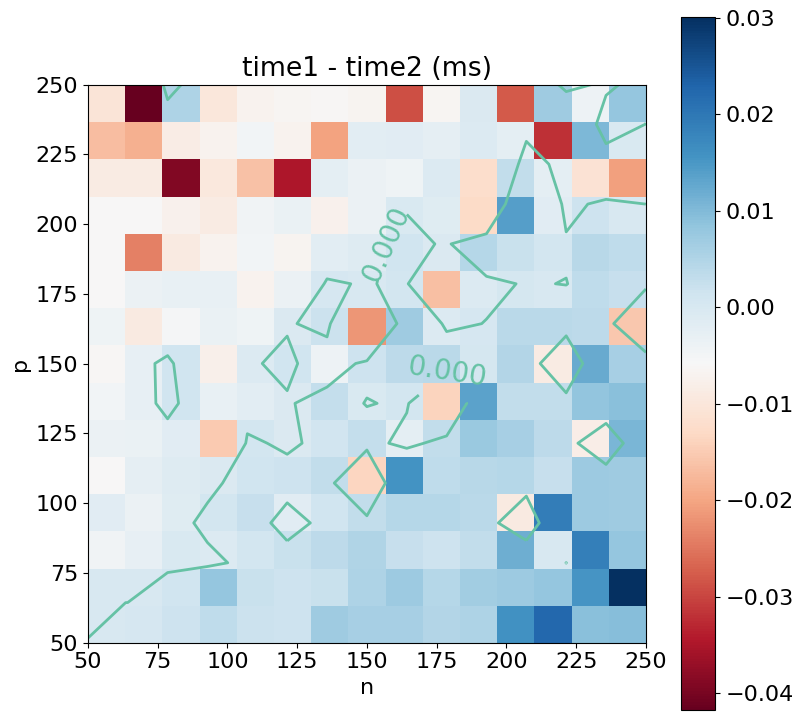

In [10]:
# It takes a lot to run!
Nt=15
table_p = np.linspace(50,250,num=Nt).astype(int)  #Create arrays of 15 evenly spaced integers between 50 and 250, representing different sizes for p (number of features) and n (number of samples).
table_n = np.linspace(50,250,num=Nt).astype(int)
time1 = np.zeros((Nt,Nt))    #Initialize Nt x Nt matrices to store the average execution time for each formula at each (n, p) combination.
time2 = np.zeros((Nt,Nt))
lamb = 0.01
Nrep = 100

for i,n in enumerate(table_n):
  for j,p in enumerate(table_p):
    X = np.random.randn(n,p)                 #Creates a random n x p matrix X with values drawn from a normal distribution. This matrix represents the features of the dataset.
    y = np.random.randn(n,1)                 #Creates a random n x 1 vector y with values drawn from a normal distribution. This vector represents the target values for ridge regression.
    time1[i][j] = timeit.timeit('inv(X.T@X+n*lamb*np.eye(p,p))@X.T@y',"from __main__ import n,p,X,y,lamb,inv,np", number=Nrep)/Nrep  #Calculates each time
    time2[i][j] = timeit.timeit('X.T@inv(X@X.T+n*lamb*np.eye(n,n))@y',"from __main__ import n,p,X,y,lamb,inv,np", number=Nrep)/Nrep

X, Y = np.meshgrid(table_n, table_p)            #Creates a 2D grid of n and p values for plotting.
Z = (time1-time2).reshape(X.shape)              #Calculates the difference in execution time.

im = plt.imshow(Z, cmap=plt.cm.RdBu, extent=(50, 250,50, 250), origin='lower')     #Displays the matrix Z as an image
cset = plt.contour(Z, [0.], linewidths=2,                                        #Adds contour lines where time1 - time2 = 0
                   cmap=plt.cm.Set2,
                  extent=(50, 250, 50, 250))

plt.clabel(cset, inline=True, fmt='%1.3f', fontsize=20)
plt.colorbar(im)
plt.xlabel('n')
plt.ylabel('p')
plt.xlim(50,250)
plt.title('time1 - time2 (ms)')
plt.ylim(50,250)

plt.show()

##Gradient Descent

An alternative to solve the problem is to use gradient descent! In order to keep numbers from exploding, we first define the cost function divided by the number of data as

$$
\mathcal{L}(\mathbf{w}) = \frac{1}{2} \left( \frac{1}{n} \| \mathbf{y} - X \mathbf{w} \|_2^2 + \lambda \| \mathbf{w} \|_2^2 \right)
$$

Therefore, the gradient reads

$$
\nabla_{\mathbf{w}} \mathcal{L}(\mathbf{w}) = -\frac{1}{n} \left( X^T \mathbf{y} - X^T X \mathbf{w} \right) + \lambda \mathbf{w} = \frac{1}{n} \left( X^T (X \mathbf{w} - \mathbf{y}) \right) + \lambda \mathbf{w}
$$

We import the function norm, which allows us to compute different matrix norms, and we choose some random initial weights.

1) Calling $ \eta $ the step size and $ t_{\text{max}} $ the number of iterations, design the function $\text{gradient_descent} $ which, given $ X $, $ y $ and the parameters $ \mathbf{w}_0 $, $ t_{\text{max}} $, $ \lambda $ and $ \eta $, returns the GD estimation for $ \mathbf{w} $ and the behaviour of the cost function $ \mathcal{L}(\mathbf{w}) $ with the different time steps.

Fixing $ n = 30 $, $ p = 3 $, $ t_{\text{max}} = 50 $, $ \lambda = 0.001 $ for each value of $ \eta $ in \{0.03, 0.1, 0.3, 1, 2, 3\} :

-Use the function you designed to plot the behaviour of the cost function vs the number of iterations

-Compute the distance between the final estimation of $\mathbf{w} $ and the exact one.




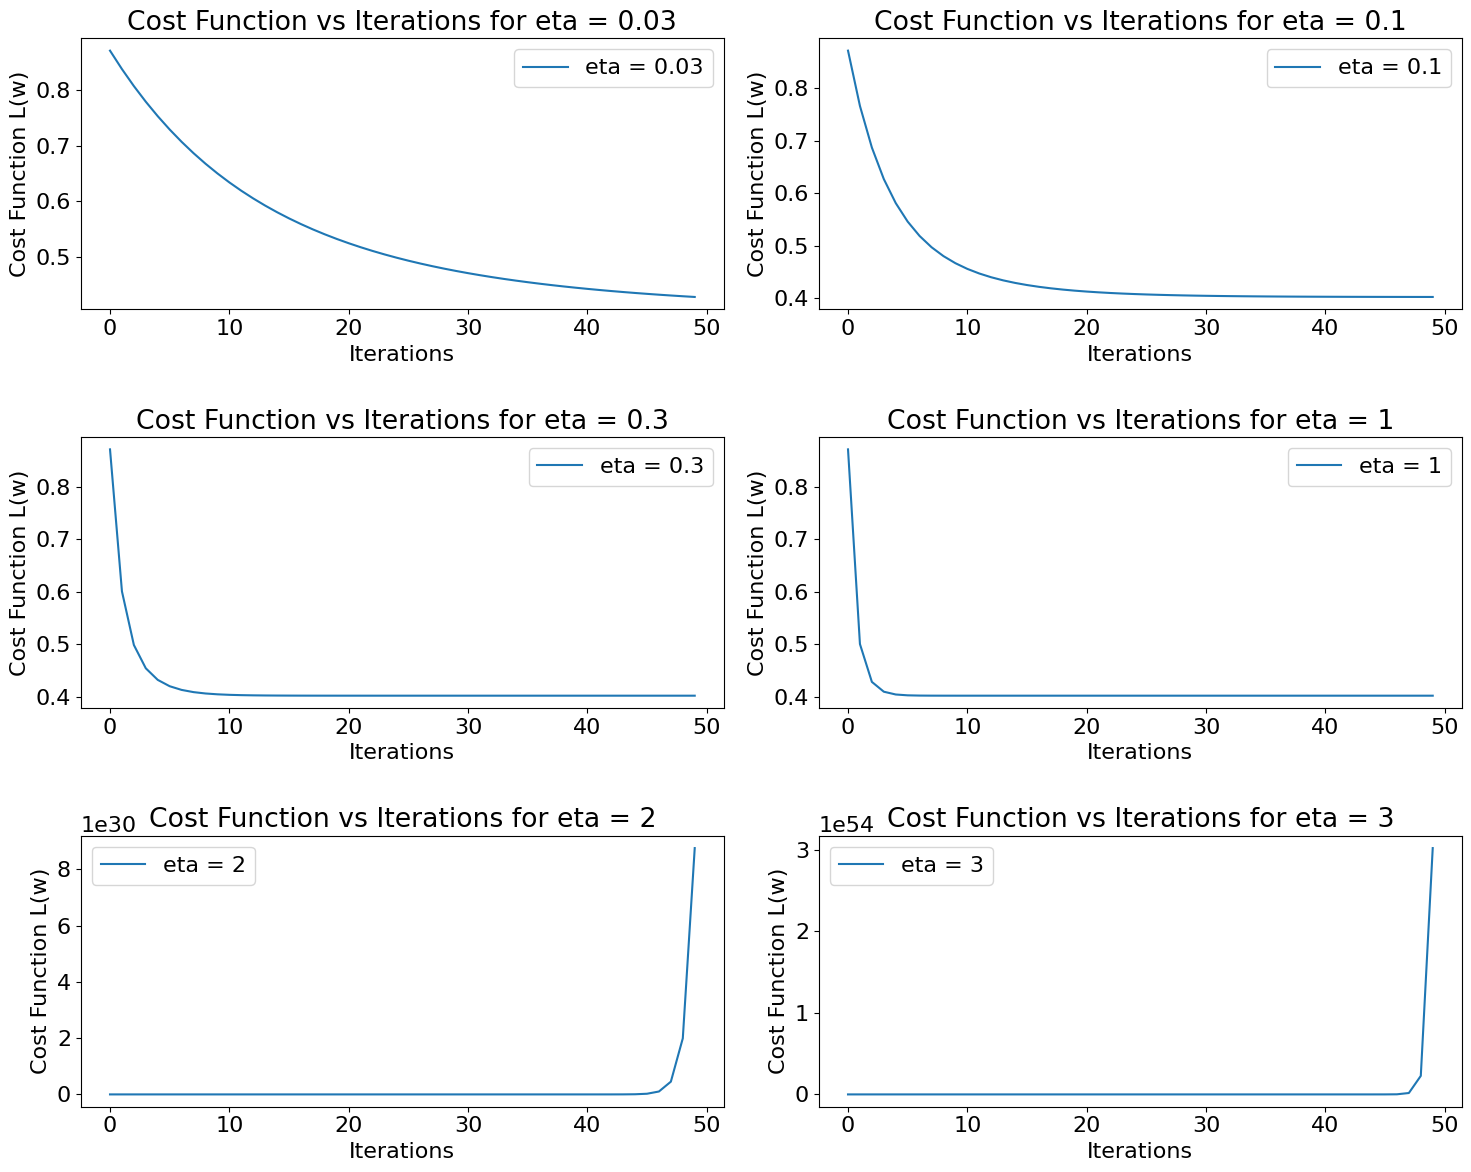

Distance between estimated w and exact w for eta = 0.03: 0.25796895239081313
Distance between estimated w and exact w for eta = 0.1: 0.01976941059880536
Distance between estimated w and exact w for eta = 0.3: 1.0739430139643464e-05
Distance between estimated w and exact w for eta = 1: 5.258477845414801e-14
Distance between estimated w and exact w for eta = 2: 7052488379316181.0
Distance between estimated w and exact w for eta = 3: 7.197594766077806e+27


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm

def gradient_descent(X, y, w0, iterations, lamb, eta):
    n, p = X.shape
    w = w0
    cost_history = []

    for _ in range(iterations):
        prediction = X @ w
        err = prediction - y

        #part 1: cost function
        cost = (1 / (2 * n)) * (np.dot(err.T, err) + lamb * np.dot(w.T, w))[0, 0]
        cost_history.append(cost)

        #part 2: gradient with L2 generalization (remember the square that we dont have in LASSO)
        gradient = (X.T @ err) / n + lamb * w

        #part 3: new weights
        w = w - eta * gradient

    return w, cost_history

n = 30                                  #points
p = 3                                   #features
t_max = 50                              #number of iterations
lamb = 0.001                            #lambda is a regularization parameter that controls the trade-off between the goodness of fit of the model to the data and the complexity of the model.
etas = [0.03, 0.1, 0.3, 1, 2, 3]        #step size or LEARNING RATE
X = np.random.randn(n, p)
y = np.random.randn(n, 1)
w0 = np.random.rand(p, 1)               # Initial random weights

#Plots
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, eta in enumerate(etas):
    w_est, cost_history = gradient_descent(X, y, w0, t_max, lamb, eta)

    #for each eta the cost function is plotted
    axes[idx].plot(cost_history, label=f"eta = {eta}")
    axes[idx].set_xlabel("Iterations")
    axes[idx].set_ylabel("Cost Function L(w)")
    axes[idx].set_title(f"Cost Function vs Iterations for eta = {eta}")
    axes[idx].legend()

plt.tight_layout()
plt.show()


# Here we assume the exact solution is the closed-form solution for ridge regression!!!
exact_w = np.linalg.inv(X.T @ X + n * lamb * np.eye(p)) @ X.T @ y
for eta in etas:
    w_est, _ = gradient_descent(X, y, w0, t_max, lamb, eta)
    distance = norm(w_est - exact_w)
    print(f"Distance between estimated w and exact w for eta = {eta}: {distance}")





At low values of
𝜂
η, the cost function generally decreases smoothly and steadily across iterations, indicating a stable convergence process. However, since each step is small, it takes many iterations to make significant progress, which can lead to slow convergence. In extreme cases, large
𝜂
η values make the cost function fluctuate or diverge, preventing convergence and indicating that the learning rate is too high for effective learning.

Also focusing on the distance, it looks like you want values of eta that are around 1 so not to small or too big.

## Ordinary Least Square and implicit regularization

Now, let's focus on the case where $n<p$ and let's compare the solution found by gradient descent when $\lambda=0$, with the one we find using just ordinary least squares:
$$
\hat{\mathbf{w}} = {\rm arg~min}_{\mathbf{w}} \quad ||\mathbf{y} - X \mathbf{w} ||_2^2
$$

We try to use the formula

$$
\hat {\mathbf w} = (X^T X )^{-1} X^T {\mathbf y}
$$

to get the solution.


In [22]:
#This is just the formula under ridge regression but we are taking lambda=0 meaning we have no regularization term that will control overfitting. The larger lambda the more we penalize large weights.
#Also full rank means all rows and columns are LI

w_ref = inv(X.T@X+n*lamb*np.eye(p,p))@X.T@y   #Ridge regression case
inv(X.T@X)@(X.T@y) - w_ref                    #Ordinary least square case, the difference then is how much the regularization term affects the solution!!

array([[ 2.19394697e-04],
       [-3.77392100e-05],
       [ 1.65436776e-04]])

Full rank, coincides with the regularized solution

Then, we can use the least norm solution:
$$
\hat {\mathbf w}_{ln} = X^T (X X^T)^{-1}  {\mathbf y}
$$

In [23]:
X.T@inv(X@X.T)@y - w_ref

array([[ 72.5502411 ],
       [  8.3032303 ],
       [-25.68678327]])

Not full rank, the solution found by the (pseudo)inverse makes no sense

In [19]:
inv(X@X.T)[0]

array([-3.19914158e+14, -6.75347429e+13,  5.65831469e+14,  9.08456640e+14,
       -2.73828375e+14,  2.23811367e+13,  6.75487396e+14, -7.61782266e+14,
       -1.06880616e+14,  1.10062589e+15, -7.02189688e+14,  6.01044731e+14,
        6.56434613e+14,  3.34046135e+14,  1.92124036e+14,  1.76538621e+15,
        7.96160042e+13, -1.41365425e+15, -1.42317574e+15, -1.94250273e+15,
       -3.99566863e+14,  4.73727387e+14,  6.81439552e+14, -1.05821465e+15,
       -5.69550420e+15,  2.63528663e+15, -1.56690712e+15, -3.14732489e+14,
        1.45415162e+15,  2.00992870e+15])

#### 2) Fix $p=100$ and $n=20$ and, taking $\lambda=0$, compare the solution obtained using $\hat{\mathbf w}_{ln}$ with
* the one obtained by gradient descent with a random initilization
* the one obtained by gradient descent with a zero initilization

#### How can you explain the differences?

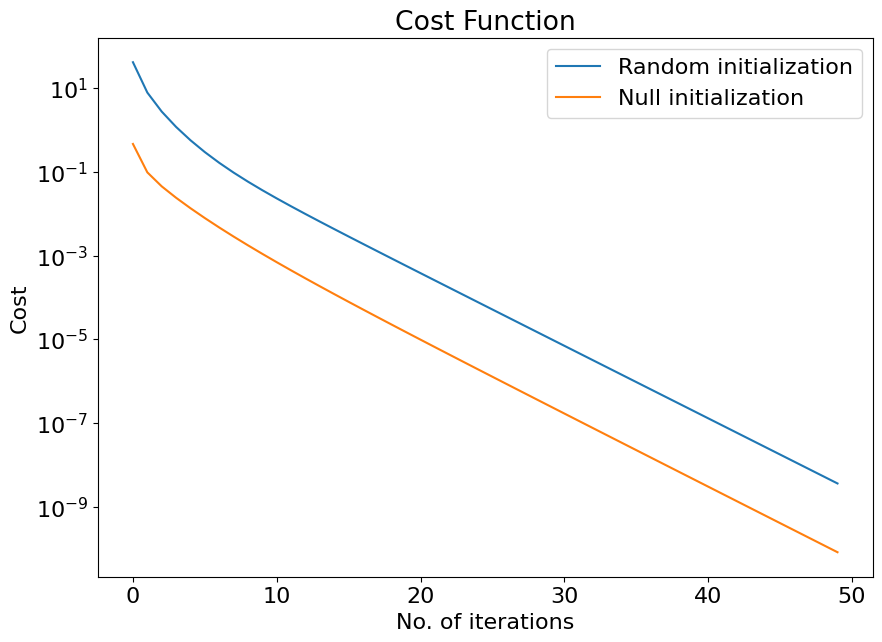

Difference of w_r from optimum w is 8.956795537536019
Difference of w_z from optimum w is 7.729075519827835e-06


In [37]:
p = 100
n = 20

X = np.random.randn(n,p)
y = np.random.randn(n,1)
lamb = 0
eta = 0.1
max = 50
w0_random = np.random.randn(p,1) #Random start values
w0_zero = np.zeros((p,1)) #Zero values

fig = plt.figure(figsize=(10,7))

w_random, past_costs_r = gradient_descent(X, y, w0_random, max, lamb, eta)
w_zero, past_costs_z = gradient_descent(X, y, w0_zero, max, lamb, eta)


plt.title('Cost Function')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.plot(past_costs_r, label='Random initialization')
plt.plot(past_costs_z, label='Null initialization')
plt.yscale('log')
plt.legend()
plt.show()


from numpy.linalg import pinv
w_ref = X.T@inv(X@X.T)@y
print(f'Difference of w_r from optimum w is {norm(w_ref - w_random)}')
print(f'Difference of w_z from optimum w is {norm(w_ref - w_zero)}')


Zero initialization leads gradient descent to a solution close to the optimal least-norm solution, while random initialization can result in a different, higher-norm solution due to the underdetermined nature of the system. (Where p>n)

## LASSO and sub-gradient descent

Another cost function that shall be useful is the one corresponding to LASSO:
$$
{\cal L}({\mathbf{w}}) =  \frac{1}{2n} ||\mathbf{y} - X \mathbf{w} ||_2^2 +  \lambda \|  \mathbf{w}\|_1
$$

One can define the subgradient as
$$
\nabla_\mathbf{w} {\cal L}(\mathbf{w}) = -\frac 1n (X^T y - X^TX \mathbf {w}) + \lambda {\rm sign} ({\mathbf w}) = \frac 1n (X^T (X {\mathbf w}-y)) + \lambda {\rm sign}({\mathbf w})
$$

#### 3) Using  `np.sign()` to implement the sign function, construct the function `gradient_descent_lasso` that returns an estimation for $w$ and the behaviour of the cost function ${\cal L}(\mathbf{w})$ with the different time steps. Having done that, use this function to plot the cost function for a new dataset with  $p=100$ and $n=20$ .

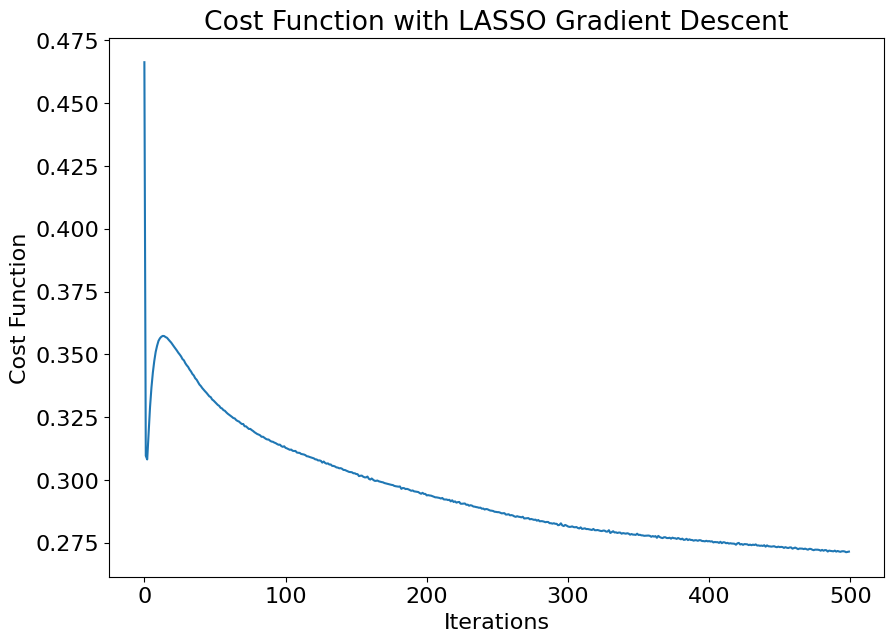

In [43]:
#Remember from class we have to use the subgradient descent as the ABSOLUTE VALUE is not differentiable.
#LASSO is similar to ridge regression but uses a L1 type error while ridge regression L2 (the absolute value of w is squared)

def gradient_descent_LASSO(X, y, w, iterations, l1, eta):
    previous_costs = []
    n= len(y)

    for i in range(iterations):
        pred =  X@w
        error = pred - y

        cost = (1/(2*n) * np.dot(error.T, error) + l1 * np.linalg.norm((w), ord=1))[0,0]
        previous_costs.append(cost)

        w = w - eta *( (1/n) * (np.dot(X.T, error)+l1*np.sign(w)))
    return w, previous_costs


p = 100
n = 20
lamb = 0.1
eta = 0.1
iterations = 500


X = np.random.randn(n, p)
y = np.random.randn(n, 1)
w0 = np.zeros((p,1))
#w0_r = np.random.randn(p,1) ,also tried with the random weight just out of curiosity

w, cost_hist = gradient_descent_LASSO(X, y, w0, iterations, lamb, eta)

plt.figure(figsize=(10, 7))
plt.title('Cost Function with LASSO Gradient Descent')
plt.xlabel('Iterations')
plt.ylabel('Cost Function')
plt.plot(cost_hist)
plt.show()

3b) Find and implement Iterative soft Thresholding algorithm to solve the LASSO problem. Compare the results with the ones obtained by the sub-gradient descent.

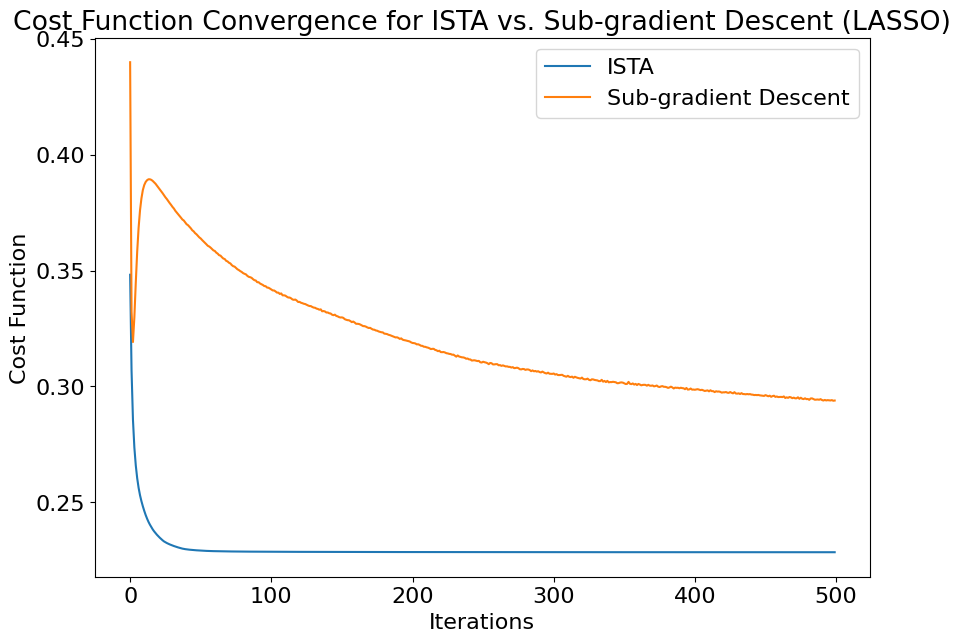

In [44]:
import numpy as np
import matplotlib.pyplot as plt

def iterative_soft_thresholding(X, y, w0, iterations, l1, eta):
    n = len(y)
    w = w0
    cost_history = []

    for i in range(iterations):
        #As before
        gradient = (X.T @ (X @ w - y)) / n
        w = w - eta * gradient

        # Soft-thresholding step
        w = np.sign(w) * np.maximum(0, np.abs(w) - eta * l1)

        #As before
        prediction = X @ w
        error = prediction - y
        cost = (1 / (2 * n)) * np.dot(error.T, error) + l1 * np.sum(np.abs(w))
        cost_history.append(cost[0, 0])

    return w, cost_history

p = 100
n = 20
lamb = 0.1
eta = 0.1
iterations = 500

X = np.random.randn(n, p)
y = np.random.randn(n, 1)
w0 = np.zeros((p, 1))

w_ista, cost_hist_ista = iterative_soft_thresholding(X, y, w0, iterations, lamb, eta)
w_subgrad, cost_hist_subgrad = gradient_descent_LASSO(X, y, w0, iterations, lamb, eta)

plt.figure(figsize=(10, 7))
plt.plot(cost_hist_ista, label='ISTA')
plt.plot(cost_hist_subgrad, label='Sub-gradient Descent')
plt.title('ISTA vs. LASSO')
plt.xlabel('Iterations')
plt.ylabel('Cost Function')
plt.legend()
plt.show()


# B) Surfaces

We will consider two simple surfaces: A quadratic minimum of the form

$$
z=ax^2+by^2\,,
$$

and the [Matyas function](https://en.wikipedia.org/wiki/Test_functions_for_optimization), a convex function often used to test optimization problems of the form:

$$
z(x,y) = 0.26(x^2 + y^2) - 0.48xy
$$

In [45]:
#Make 3D plots
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import LogNorm

#Function for plotting

def plot_surface(x, y, z, azim=-60, elev=40, dist=10, cmap="RdYlBu_r"):

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plot_args = {'rstride': 1, 'cstride': 1, 'cmap':cmap, 'linewidth': 20, 'antialiased': True, 'vmin': -2, 'vmax': 2} #parameters for the plots
    ax.plot_surface(x, y, z, **plot_args)
    ax.view_init(azim=azim, elev=elev) #point of view
    ax.dist=dist
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-2, 2)

    plt.xticks([-1, -0.5, 0, 0.5, 1], ["-1", "-1/2", "0", "1/2", "1"])
    plt.yticks([-1, -0.5, 0, 0.5, 1], ["-1", "-1/2", "0", "1/2", "1"])
    ax.set_zticks([-2, -1, 0, 1, 2])
    ax.set_zticklabels(["-2", "-1", "0", "1", "2"])

    ax.set_xlabel("x", fontsize=18)
    ax.set_ylabel("y", fontsize=18)
    ax.set_zlabel("z", fontsize=18)
    return fig, ax;

#Overlay the trajectory of GD on a contour plot

def overlay_trajectory_contour(ax,trajectory, label,color='k',lw=2):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    ax.plot(xs,ys, color, label=label,lw=lw)
    return ax;

We now define the functions for the Matyas function and the respective gradient, that we will need for the algorithms:

In [52]:
def matyas_surf(x,y):
    return 0.26*(x**2 + y**2) - 0.48*x*y

def grad_matyas_surface(params):
    x=params[0]
    y=params[1]
    grad_x= 0.52*x-0.48*y
    grad_y= 0.52*y-0.48*x
    return [grad_x,grad_y]

4) Now do the  same for the quadratic minimum surface

In [53]:
def minima_surf(x,y,a=1,b=1):
    return a*x**2+b*y**2-1

def grad_minima_surface(params,a=1,b=1):
    x=params[0]
    y=params[1]
    grad_x= 2*a*x
    grad_y= 2*b*y
    return [grad_x,grad_y]

## Gradient descent with and without momentum

Now, let's visualize various gradient descent algorithms used in machine learning. We will be especially interested in trying to understand how various hyperparameters, especially the learning rate, affect our performance.

As always, we will work with some parameters $\mathbf{w}$ and we have an energy function we are trying to minimize, usually denoted by ${\cal L}(\mathbf{w})$.

<b>Gradient Descent</b>

We start by considering a simple gradient descent method. In this method,
we will take steps in the direction of the local gradient. Given some parameters $\mathbf{w}$, we adjust them at each iteration so that

$$\mathbf{w}_{t+1}= \mathbf{w}_t - \eta_t \nabla_\mathbf{w} {\cal L}(\mathbf{w}),$$

where we have introduced the learning rate $\eta_t$ that controls how large a step we take. In general, the algorithm is extremely sensitive to the choice of $\eta_t$. If $\eta_t$ is too large, then one can wildly oscillate around minima and miss important structure at small scales. This problem is amplified if our gradient computations are noisy and inexact (as is often the case in machine learning applications). If $\eta_t$ is too small, then the learning/minimization procedure becomes extremely slow. This raises the natural question: <i> What sets the natural scale for the learning rate and how can we adaptively choose it?</i>

<b>Gradient Descent with Momentum</b>

One problem with gradient descent is that it has no memory of where the "ball rolling down the hill" comes from. This can be an issue when there are many shallow minima in our landscape. If we make an analogy with a ball rolling down a hill, the lack of memory is equivalent to having no inertia or momentum (i.e. completely overdamped dynamics). Without momentum, the ball has no kinetic energy and cannot climb out of shallow minima.

Momentum becomes especially important when we start thinking about **stochastic gradient descent** with noisy, stochastic estimates of the gradient. In this case, we should remember where we were coming from and not react drastically to each new update.



Inspired by this, we can add a memory or momentum term to the stochastic gradient descent term above:

$$
v_{t}=\gamma v_{t-1}+\eta_{t}\nabla_\mathbf{w} {\cal L}(\mathbf{w}_t),\\
\mathbf{w}_{t+1}= \mathbf{w}_t -v_{t},
$$

with $0\le \gamma < 1$ called the momentum parameter. When $\gamma=0$, this reduces to ordinary gradient descent, and increasing $\gamma$ increases the inertial contribution to the gradient. From the equations above, we can see that typical memory lifetimes of the gradient is given by $(1-\gamma)^{-1}$. For $\gamma=0$ as in gradient descent, the lifetime is just one step. For $\gamma=0.9$, we typically remember a gradient for ten steps. We will call this gradient descent with **classical momentum** or CM for short.

**NAG**

A final widely used variant of gradient descent with momentum is called the Nesterov accelerated gradient (NAG). In NAG, rather than calculating the gradient at the current position, one calculates the gradient at the position momentum will carry us to at time $t+1$, namely, $\mathbf{w}_t -\gamma v_{t-1}$. Thus, the update becomes
$$
v_{t}=\gamma v_{t-1}+\eta_{t}\nabla_\mathbf{w} {\cal L}(\mathbf{w}_t-\gamma v_{t-1})\\
\mathbf{w}_{t+1}= \mathbf{w}_t -v_{t}
$$

5) Now write yourself the functions implementing GD with CM and NAG

In [54]:
def gd(grad, init, n_epochs=1000, eta=10**-4, noise_strength=0):
    #Couple of initialization parameters
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0;
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)   #Creates gaussian noise
        v=eta*(np.array(grad(params))+noise)                #The gradient plus noise is scaled by the learning rate eta, giving v, the update vector for the current iteration. Adding noise to the gradient allows exploration of the parameter space.
        params=params-v                                     #wt+1=wt−ηt∇wL(w)
        param_traj[j+1,]=params                             #The updated parameters are saved in param_traj for later analysis or visualization
    return param_traj

def gd_CM(grad, init, n_epochs=1000, eta=10**-4, gamma=0.9, noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        v=gamma*v+eta*(np.array(grad(params))+noise)       #new factor gamma*eta
        params=params-v
        param_traj[j+1,]=params
    return param_traj

def gd_NAG(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9, noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        Nestrov_wt=params-gamma*v                                   #implement the new Nestrov wt
        v=gamma*v+eta*(np.array(grad(Nestrov_wt))+noise)            #plug in the Nestrov_wt
        params=params-v
        param_traj[j+1,]=params
    return param_traj

## Experiments with GD, CM, and NAG

Let us play with these methods to gain some intuition.

Let's look at the dependence of GD on learning rate in the Matyas surface. We do the plot below for $\eta=0.1, 0.5, 1, 2$.
- What are the qualitatively different behaviors that arise as $\eta$ is increased?
- What does this tell us about the importance of choosing learning parameters?

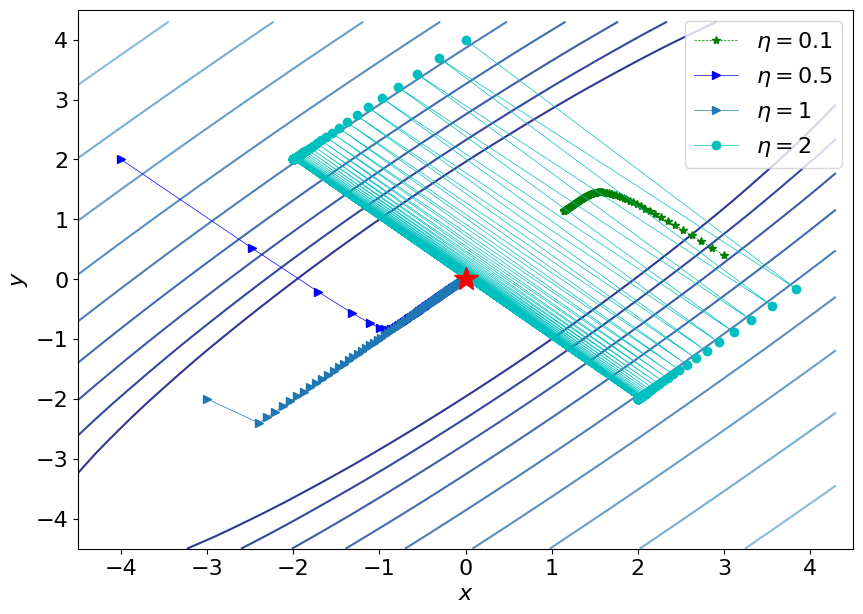

In [55]:
# Investigate effect of learning rate in GD
plt.close()
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(111)
x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), np.arange(-4.5, 4.5, 0.2))
z=np.abs(matyas_surf(x,y))

#initial point
init4=[0,4]
init2=[-4,2]
init3=[-3,-2]
init1=[3,0.4]
eta1=0.1
eta2=0.5
eta3=1
eta4=2

ax1.contour(x, y, z, levels=np.logspace(0.0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')

ax1.set_xlim((-4.5, 4.5))
ax1.set_ylim((-4.5, 4.5))

gd_1=gd(grad_matyas_surface,init1, n_epochs=100, eta=eta1)
gd_2=gd(grad_matyas_surface,init2, n_epochs=100, eta=eta2)
gd_3=gd(grad_matyas_surface,init3, n_epochs=100, eta=eta3)
gd_4=gd(grad_matyas_surface,init4, n_epochs=100, eta=eta4)

overlay_trajectory_contour(ax1,gd_1,'$\eta=$%s'% eta1,'g--*', lw=0.5)
overlay_trajectory_contour(ax1,gd_2,'$\eta=$%s'% eta2,'b->', lw=0.5)
overlay_trajectory_contour(ax1,gd_3,'$\eta=$%s'% eta3,'->', lw=0.5)
overlay_trajectory_contour(ax1,gd_4,'$\eta=$%s'% eta4,'c-o', lw=0.5)

ax1.plot(0,0, 'r*', markersize=18)

plt.legend()
plt.show()

Small 𝜂 show slow, steady progress towards the minimum, with stable convergence. Moderate 𝜂 (0.5) show faster convergence without overshooting, showing a good balance. High 𝜂 (1) and we have oscillating near the minimum due to overshooting. Very High eta (2) and the solution diverges completely, moving away from the minimum.

6) Do the same for the quadratic minimum. How do these change if we change $a$ and $b$ above? In particular how does anisotropy change the learning behavior?

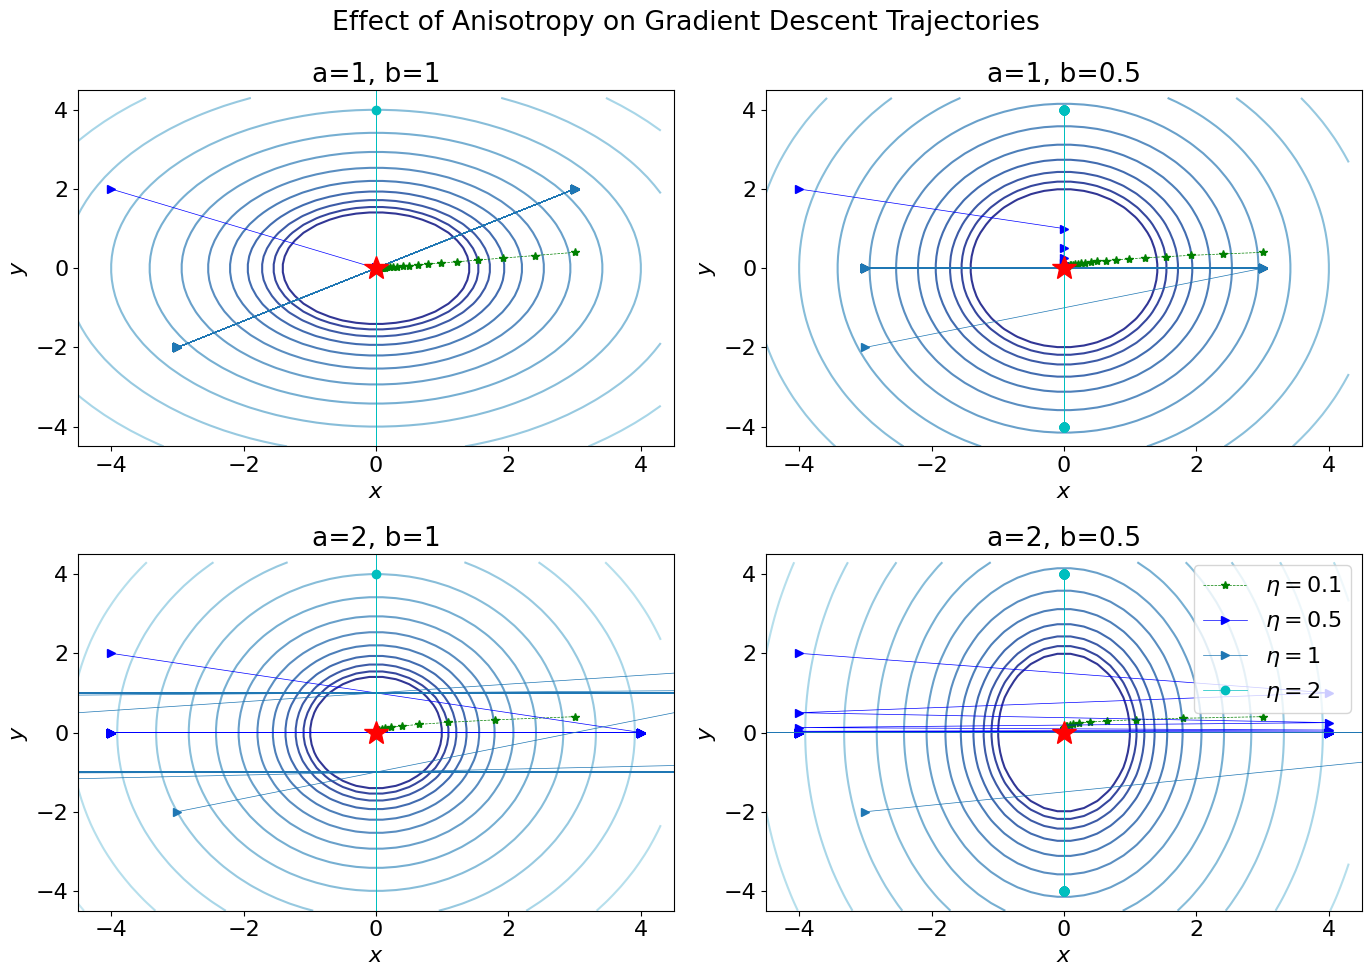

In [64]:
a_values = [1, 2]  #two values for a
b_values = [1, 0.5]  #two values for b

eta1 = 0.1
eta2 = 0.5
eta3 = 1
eta4 = 2
init1 = [3, 0.4]
init2 = [-4, 2]
init3 = [-3, -2]
init4 = [0, 4]

plt.close()
fig, axs = plt.subplots(len(a_values), len(b_values), figsize=(14, 10))
fig.suptitle("Gradient Descent Trajectories")

#We need two loops as we have a and b
for i, a in enumerate(a_values):
    for j, b in enumerate(b_values):

        ax = axs[i, j]

        x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), np.arange(-4.5, 4.5, 0.2))
        z = np.abs(minima_surf(x, y, a, b))

        ax.contour(x, y, z, levels=np.logspace(0.0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
        ax.set_title(f"a={a}, b={b}")
        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')
        ax.set_xlim((-4.5, 4.5))
        ax.set_ylim((-4.5, 4.5))

        gd_1 = gd(lambda params: grad_minima_surface(params, a, b), init1, n_epochs=100, eta=eta1)  #We need the lambda wrapper function as grad_minima_surface relies also on a and b
        gd_2 = gd(lambda params: grad_minima_surface(params, a, b), init2, n_epochs=100, eta=eta2)
        gd_3 = gd(lambda params: grad_minima_surface(params, a, b), init3, n_epochs=100, eta=eta3)
        gd_4 = gd(lambda params: grad_minima_surface(params, a, b), init4, n_epochs=100, eta=eta4)

        overlay_trajectory_contour(ax, gd_1, '$\eta=$%s' % eta1, 'g--*', lw=0.5)
        overlay_trajectory_contour(ax, gd_2, '$\eta=$%s' % eta2, 'b->', lw=0.5)
        overlay_trajectory_contour(ax, gd_3, '$\eta=$%s' % eta3, '->', lw=0.5)
        overlay_trajectory_contour(ax, gd_4, '$\eta=$%s' % eta4, 'c-o', lw=0.5)

        ax.plot(0, 0, 'r*', markersize=18)

plt.legend(loc="upper right")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


- **Symmetric Case (Top-Left, \( a = 1, b = 1 \))**:
  - Circular contours.
  - Stable convergence with moderate learning rates.
  - Slight oscillations with higher rates.

- **Mild Anisotropy (Top-Right, \( a = 2, b = 1 \))**:
  - Elongated along the \( x \)-axis.
  - Increased oscillations along the \( x \)-direction at higher learning rates.

- **Moderate Anisotropy (Bottom-Left, \( a = 1, b = 0.5 \))**:
  - Stretched along the \( y \)-axis.
  - Higher learning rates cause oscillations along the \( y \)-direction.

- **High Anisotropy (Bottom-Right, \( a = 2, b = 0.5 \))**:
  - Strong stretching in both directions.
  - High learning rates cause divergence along both axes.

Basically high anisotropy increases oscillations in gradient descent!


7) Make similar plots for CM and NAG. How do the learning rates for these procedures compare with those for GD?

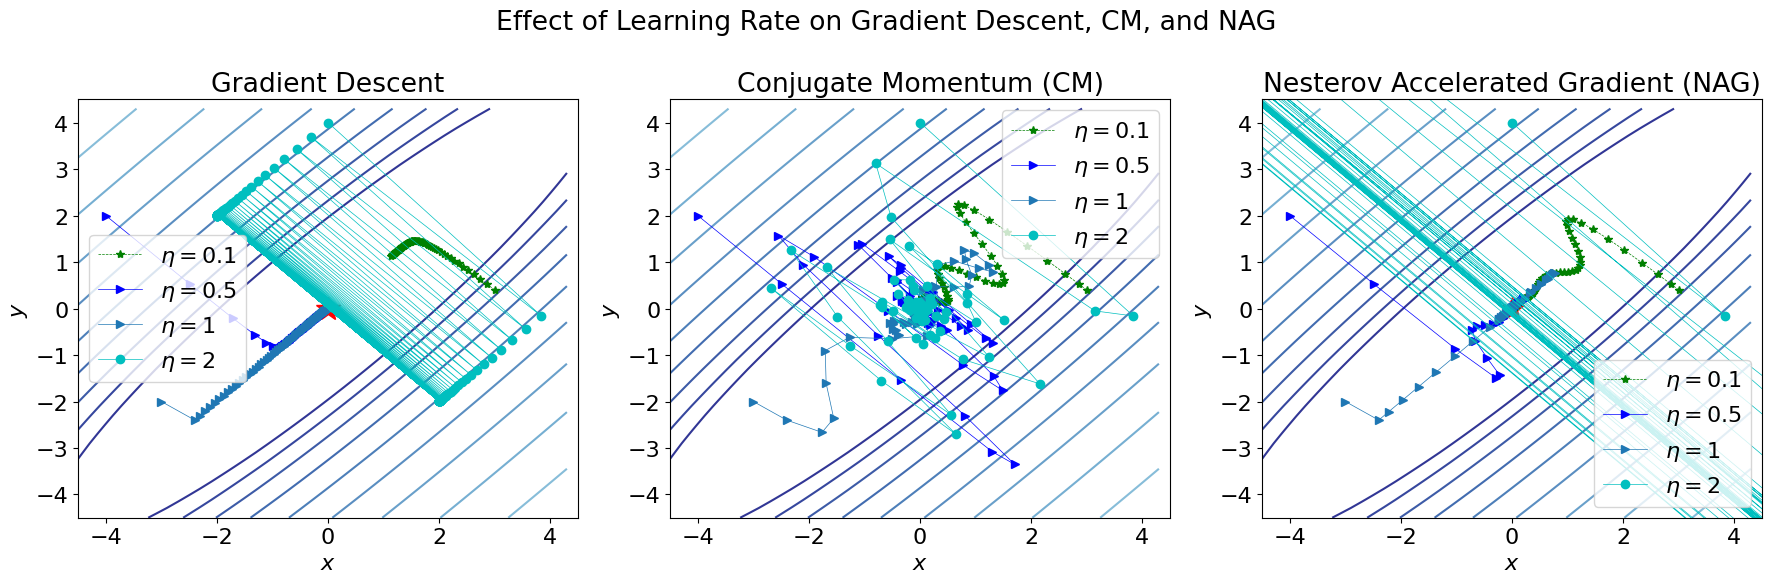

In [66]:
init_points = [[3, 0.4], [-4, 2], [-3, -2], [0, 4]]
learning_rates = [0.1, 0.5, 1, 2]

x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), np.arange(-4.5, 4.5, 0.2))        #plot for Mathyas surface
z = np.abs(matyas_surf(x, y))

fig, axs = plt.subplots(1, 3, figsize=(18, 6))                     #and plot for GD, CM, and NAG
fig.suptitle("Effect of Learning Rate on Gradient Descent, CM, and NAG")


def overlay_trajectory_contour(ax, traj, label, style, lw=0.5):    #function to overlay the plots
    ax.plot(traj[:, 0], traj[:, 1], style, label=label, lw=lw)

methods = ['GD', 'CM', 'NAG']
for ax, method in zip(axs, methods):
    ax.contour(x, y, z, levels=np.logspace(0.0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_xlim((-4.5, 4.5))
    ax.set_ylim((-4.5, 4.5))
    ax.plot(0, 0, 'r*', markersize=18)


for i, (init, eta) in enumerate(zip(init_points, learning_rates)):
    # GD
    gd_traj = gd(grad_matyas_surface, init, n_epochs=100, eta=eta)
    overlay_trajectory_contour(axs[0], gd_traj, f'$\eta={eta}$', style=['g--*', 'b->', '->', 'c-o'][i])

    # CM
    cm_traj = gd_CM(grad_matyas_surface, init, n_epochs=100, eta=eta, gamma=0.9)
    overlay_trajectory_contour(axs[1], cm_traj, f'$\eta={eta}$', style=['g--*', 'b->', '->', 'c-o'][i])

    # NAG
    nag_traj = gd_NAG(grad_matyas_surface, init, n_epochs=100, eta=eta, gamma=0.9)
    overlay_trajectory_contour(axs[2], nag_traj, f'$\eta={eta}$', style=['g--*', 'b->', '->', 'c-o'][i])

axs[0].set_title("Gradient Descent")
axs[1].set_title("Conjugate Momentum (CM)")
axs[2].set_title("Nesterov Accelerated Gradient (NAG)")

for ax in axs:
    ax.legend()

plt.tight_layout()
plt.show()


It would seem that CM helps convergence at high eta's while NAG helps convergence at low ones.